In [216]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils, util
import ccores.cores as cores
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from scipy.ndimage.measurements import label
from utils import constants as cnst

In [215]:
cd ..

/home/ck/pythonWorkspace


In [217]:
from utils import u_grid, u_interpolate as u_int
import glob


met_folder = cnst.ext_drive+'NFLICS/'
files = glob.glob(met_folder + 'IR_108_BT_20200906_0100.nc')
ds = xr.open_dataset(files[0], decode_times=False)

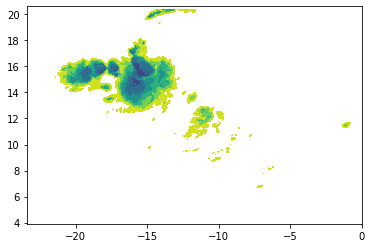

In [218]:
dlon = ds['lon_2d'].squeeze().values.T
dlat = ds['lat_2d'].squeeze().values.T
plt.contourf(dlon, dlat, ds['IR108_BT'].squeeze().T, levels=np.arange(-90,-50,5))

In [219]:
files

['/media/ck/LStorage/NFLICS/IR_108_BT_20200906_0100.nc']

In [220]:
data_resolution = 5 # in km
# make salem grid
grid5k = u_grid.make(np.arange(-19,10), np.arange(5,20), data_resolution*1000)
dlon = ds['lon_2d'].squeeze().values.T
dlat = ds['lat_2d'].squeeze().values.T
inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid5k)

data = ds['IR108_BT'].squeeze().values.T
try:
    orig5k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lon5k, lat5k = grid5k.ll_coordinates

ff = os.path.basename(files[0])
year = ff[10:14]
month = ff[14:16]
day = ff[16:18]
hour = ff[19:21]
minute = ff[21:23]


date = [datetime(int(year), int(month), int(day), int(hour), int(minute))]

In [221]:
data_resolution = 3 # in km
# make salem grid
grid3k = u_grid.make(np.arange(-19,10), np.arange(5,20), data_resolution*1000)
dlon = ds['lon_2d'].squeeze().values.T
dlat = ds['lat_2d'].squeeze().values.T
inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid3k)

data = ds['IR108_BT'].squeeze().values.T
try:
    orig3k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lon3k, lat3k = grid3k.ll_coordinates

ff = os.path.basename(files[0])
year = ff[10:14]
month = ff[14:16]
day = ff[16:18]
hour = ff[19:21]
minute = ff[21:23]


date = [datetime(int(year), int(month), int(day), int(hour), int(minute))]

In [222]:
regrid3k = grid3k.to_dataset()

In [223]:
regrid5k = grid5k.to_dataset()

In [234]:
#NFLICS nowcast standard routine
wObj = cores.dataset('METEOSAT5K_vera')
wObj.read_img(orig5k, lon5k, lat5k, edge_smoothing=True)
wObj.applyWavelet(normed='scale')
v5nflics = wObj.scaleWeighting(wtype='nflics', data_tag='MSG')

Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -87.90549480045982 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting


In [247]:
wObj2 = cores.dataset('METEOSAT3K_veraLS')
wObj2.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj2.applyWavelet(normed='scale')
v3nflics = wObj2.scaleWeighting(wtype='nflics') #big domain small scale variable routine

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -88.00945690088491 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting


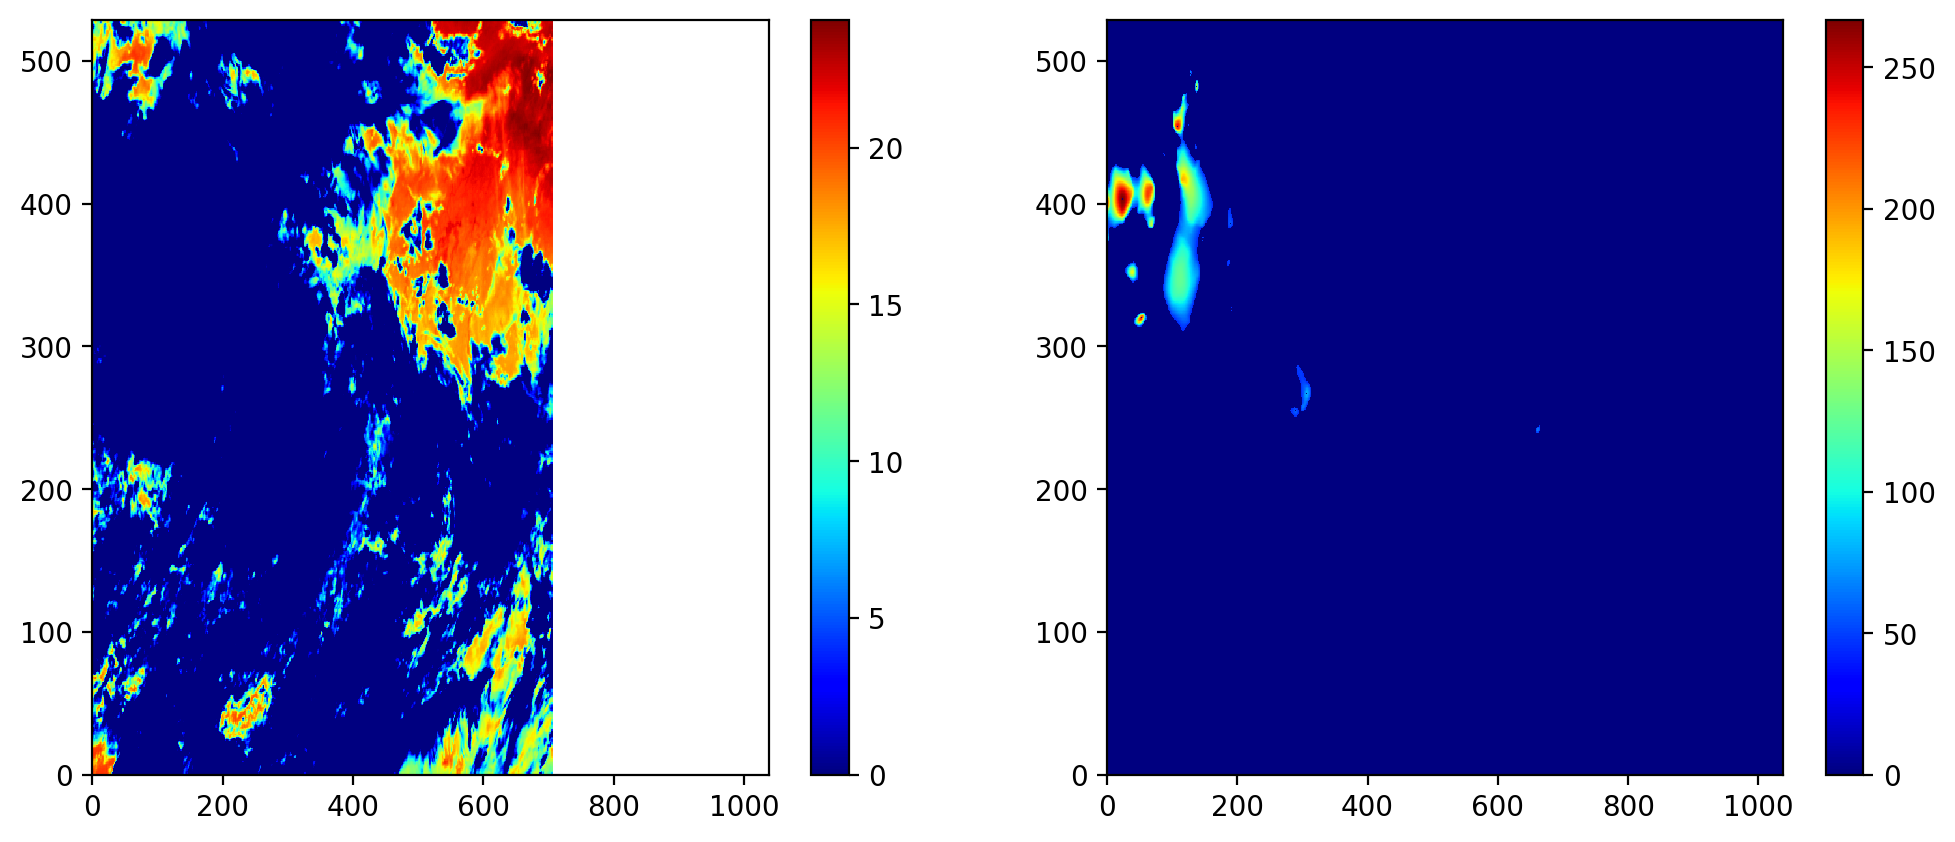

In [248]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(orig3k, cmap='jet', vmin=0)
plt.colorbar()
ax = f.add_subplot(122)
plt.pcolormesh(v3nflics, cmap='jet', vmin=0)
plt.colorbar()

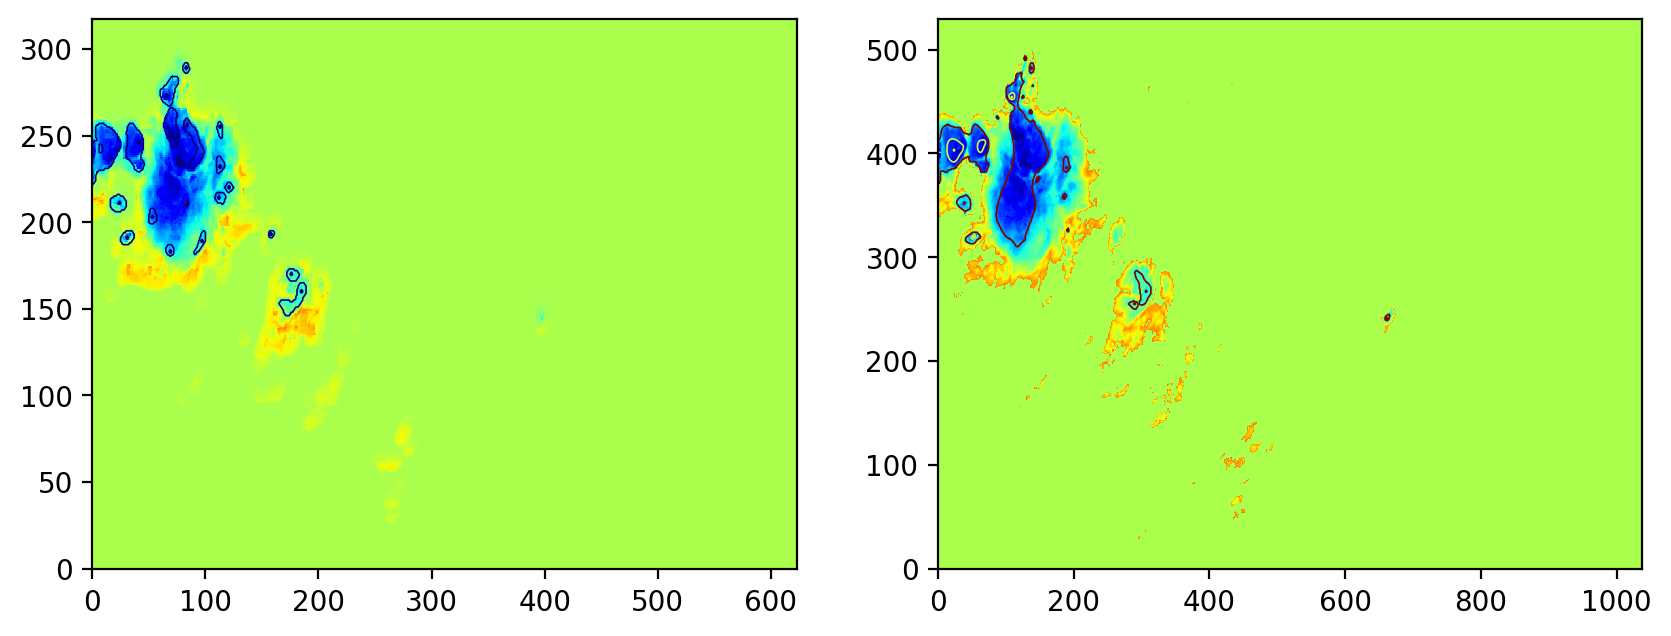

In [262]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)

# plt.pcolormesh(wObj.image, vmax=-65, vmin=-85, cmap='jet')
# plt.contour(old_nflics5k, levels=[0,1], cmap='jet_r', linewidths=0.6)

plt.pcolormesh(wObj.image, vmax=-40, vmin=-85, cmap='jet')
plt.contour(v5nflics, levels=[-1,0], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(222)
plt.pcolormesh(wObj2.image, vmax=-40, vmin=-85, cmap='jet')
plt.contour(v3nflics, levels=[-1,0,200,500], cmap='jet_r', linewidths=0.6)

# ax = f.add_subplot(223)
# plt.pcolormesh(np.array(old_nflics5k>0).astype(int)-np.array(v5knflics>0).astype(int), cmap='jet', vmin=-0.05, vmax=0.05)  #old_nflics5k   ,   v5knflicsv2

# plt.colorbar()
# ax = f.add_subplot(224)
# plt.pcolormesh(np.array(v3knflicsv2<0).astype(int)-np.array(old_nflics3k<0).astype(int), cmap='jet', vmin=-0.05, vmax=0.05)
# plt.colorbar()

In [263]:
prcp = xr.open_dataset(glob.glob('/media/ck/LStorage/NFLICS/GPM/2020/09/3B-HHR.MS.MRG.3IMERG.20200906*.0030.V06B*')[0])  #, group='/Grid/'
prcp = prcp['precipitationCal'].squeeze()
#prcp = prcp['IRprecipitation'].squeeze()
# pbox = prcp.sel(lat=slice(np.min(latitudes), np.max(latitudes)), lon=slice(np.min(longitudes),np.max(longitudes)))
prcp = prcp.sel(lon=slice(-19,0), lat=slice(8,18.5))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: linewidths is ignored by contourf
  if sys.path[0] == '':


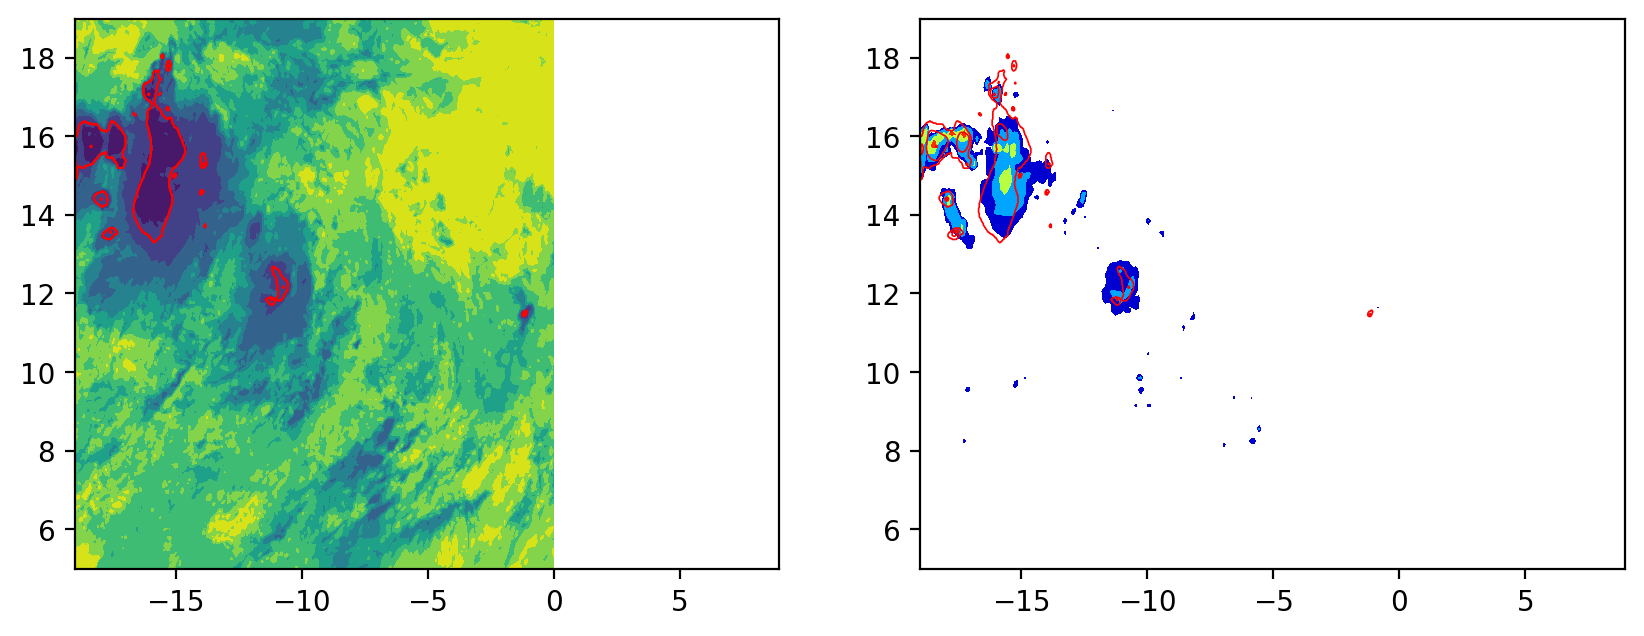

In [264]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)

plt.contourf(lon3k, lat3k, wObj2.original, cmap='viridis')
#plt.contour(prcp.lon, prcp.lat, prcp.T, cmap='jet_r', linewidths=0.6, levels=[5,10,20,30,40])
plt.contour(lon3k, lat3k, v3nflics, colors='r', linewidths=0.6, levels=[5,10,20,30])
ax = f.add_subplot(222)
# plt.pcolormesh(wObj2.image, vmax=-65, vmin=-85, cmap='jet')
# plt.contour(v3knflicsv2, levels=[0,1], cmap='jet_r', linewidths=0.6)

#plt.contourf(lon5k, lat5k, wObj.image, cmap='jet')
plt.contourf(prcp.lon, prcp.lat, prcp.T, cmap='jet', linewidths=0.6, levels=[5,10,20,30,40])
#plt.contour(lon3k, lat3k, v3nflics, cmap='jet_r', linewidths=0.6, levels=[5,10,20,30])
plt.contour(lon3k, lat3k, v3nflics, colors='r', linewidths=0.6, levels=[-1,0,150])